# A look at solution data and processed variables

Once you have run a simulation the first thing you want to do is have a look at the data. Most of the examples so far have made use of PyBaMM's handy QuickPlot function but there are other ways to access the data and this notebook will explore them. First off we will generate a standard SPMe model and use QuickPlot to view the default variables.

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

# load model
model = pybamm.lithium_ion.SPMe()

# set up and solve simulation
simulation = pybamm.Simulation(model)
dt = 90
t_eval = np.arange(0, 3600, dt)  # time in seconds
solution = simulation.solve(t_eval)

quick_plot = pybamm.QuickPlot(solution)
quick_plot.dynamic_plot();

Note: you may need to restart the kernel to use updated packages.


interactive(children=(FloatSlider(value=0.0, description='t', max=3510.0, step=35.1), Output()), _dom_classes=…

Behind the scenes the QuickPlot classed has created some processed variables which can interpolate the model variables for our solution and has also stored the results for the solution steps

In [2]:
solution.data.keys()

dict_keys(['Negative particle surface concentration [mol.m-3]', 'Electrolyte concentration [mol.m-3]', 'Positive particle surface concentration [mol.m-3]', 'Current [A]', 'Negative electrode potential [V]', 'Electrolyte potential [V]', 'Positive electrode potential [V]', 'Voltage [V]'])

In [3]:
solution.data['Negative particle surface concentration [mol.m-3]'].shape

(20, 40)

In [4]:
solution.t.shape

(40,)

Notice that the dictionary keys are in the same order as the subplots in the QuickPlot figure. We can add new processed variables to the solution by simply using it like a dictionary. First let's find a few more variables to look at. As you will see there are quite a few:

In [5]:
keys = list(model.variables.keys())
keys.sort()
print(keys)

['Ambient temperature', 'Ambient temperature [K]', 'Average negative particle concentration', 'Average negative particle concentration [mol.m-3]', 'Average positive particle concentration', 'Average positive particle concentration [mol.m-3]', 'Battery voltage [V]', 'C-rate', 'Cell temperature', 'Cell temperature [K]', 'Change in measured open-circuit voltage', 'Change in measured open-circuit voltage [V]', 'Current [A]', 'Current collector current density', 'Current collector current density [A.m-2]', 'Discharge capacity [A.h]', 'Electrode current density', 'Electrode tortuosity', 'Electrolyte concentration', 'Electrolyte concentration [Molar]', 'Electrolyte concentration [mol.m-3]', 'Electrolyte current density', 'Electrolyte current density [A.m-2]', 'Electrolyte flux', 'Electrolyte flux [mol.m-2.s-1]', 'Electrolyte potential', 'Electrolyte potential [V]', 'Electrolyte tortuosity', 'Exchange current density', 'Exchange current density [A.m-2]', 'Exchange current density per volume [A

If you want to find a particular variable you can search the variables dictionary

In [6]:
model.variables.search("time")

Time
Time [h]
Time [min]
Time [s]


We'll use the time in hours

In [7]:
solution['Time [h]']

This created a new processed variable and stored it on the solution object

In [8]:
solution.data.keys()

dict_keys(['Negative particle surface concentration [mol.m-3]', 'Electrolyte concentration [mol.m-3]', 'Positive particle surface concentration [mol.m-3]', 'Current [A]', 'Negative electrode potential [V]', 'Electrolyte potential [V]', 'Positive electrode potential [V]', 'Voltage [V]', 'Time [h]'])

We can see the data by simply accessing the entries attribute of the processed variable

In [9]:
solution['Time [h]'].entries

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975])

We can also call the method with specified time(s) in SI units of seconds

In [10]:
time_in_seconds = np.array([0, 600, 900, 1700, 3000 ])

In [11]:
solution['Time [h]'](time_in_seconds)

array([0.        , 0.16666667, 0.25      , 0.47222222, 0.83333333])

If the variable has not already been processed it will be created behind the scenes

In [12]:
var = 'X-averaged negative electrode temperature [K]'
solution[var](time_in_seconds)

array([298.15, 298.15, 298.15, 298.15, 298.15])

In this example the simulation was isothermal, so the temperature remains unchanged.

## Saving the solution

The solution can be saved in a number of ways:

In [13]:
# to a pickle file (default)
solution.save_data(
    "outputs.pickle", ["Time [h]", "Current [A]", "Voltage [V]", "Electrolyte concentration [mol.m-3]"]
)
# to a matlab file
# need to give variable names without space
solution.save_data(
    "outputs.mat", 
    ["Time [h]", "Current [A]", "Voltage [V]", "Electrolyte concentration [mol.m-3]"], 
    to_format="matlab",
    short_names={
        "Time [h]": "t", "Current [A]": "I", "Voltage [V]": "V", "Electrolyte concentration [mol.m-3]": "c_e",
    }
)
# to a csv file (time-dependent outputs only, no spatial dependence allowed)
solution.save_data(
    "outputs.csv", ["Time [h]", "Current [A]", "Voltage [V]"], to_format="csv"
)

## Stepping the solver

The previous solution was created in one go with the solve method, but it is also possible to step the solution and look at the results as we go. In doing so, the results are automatically updated at each step.

In [14]:
dt = 360
time = 0
end_time = solution["Time [s]"].entries[-1]
step_simulation = pybamm.Simulation(model)
while time < end_time:
    step_solution = step_simulation.step(dt)
    print('Time', time)
    print(step_solution["Voltage [V]"].entries)
    time += dt

Time 0
[3.77047806 3.71250693]
Time 360
[3.77047806 3.71250693 3.68215218]
Time 720
[3.77047806 3.71250693 3.68215218 3.66125574]
Time 1080
[3.77047806 3.71250693 3.68215218 3.66125574 3.64330942]
Time 1440
[3.77047806 3.71250693 3.68215218 3.66125574 3.64330942 3.61166857]
Time 1800
[3.77047806 3.71250693 3.68215218 3.66125574 3.64330942 3.61166857
 3.59709451]
Time 2160
[3.77047806 3.71250693 3.68215218 3.66125574 3.64330942 3.61166857
 3.59709451 3.58821334]
Time 2520
[3.77047806 3.71250693 3.68215218 3.66125574 3.64330942 3.61166857
 3.59709451 3.58821334 3.58056055]
Time 2880
[3.77047806 3.71250693 3.68215218 3.66125574 3.64330942 3.61166857
 3.59709451 3.58821334 3.58056055 3.55158694]
Time 3240
[3.77047806 3.71250693 3.68215218 3.66125574 3.64330942 3.61166857
 3.59709451 3.58821334 3.58056055 3.55158694 3.16842636]


We can plot the voltages and see that the solutions are the same

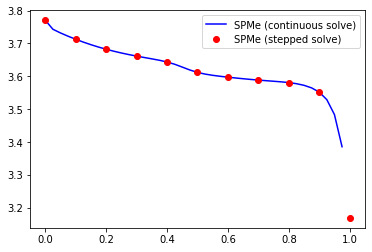

In [15]:
voltage = solution["Voltage [V]"].entries
step_voltage = step_solution["Voltage [V]"].entries
plt.figure()
plt.plot(solution["Time [h]"].entries, voltage, "b-", label="SPMe (continuous solve)")
plt.plot(
    step_solution["Time [h]"].entries, step_voltage, "ro", label="SPMe (stepped solve)"
)
plt.legend()

As a final step, we will clean up the output files created by this notebook:

In [ ]:
os.remove("outputs.csv")
os.remove("outputs.mat")
os.remove("outputs.pickle")

## References

The relevant papers for this notebook are:

In [16]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/2.0341915jes.
[4] Valentin Sulzer, Scott G. Marquis, Robert Timms, Martin Robinson, and S. Jon Chapman. Python Battery Mathematical Modelling (PyBaMM). ECSarXiv. February, 2020. doi:10.1149/osf.io/67ckj.
